In [3]:
# Ket noi google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install ultralytics
# !pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.4 MB/s eta 0:00:00


In [15]:
import os
import cv2
import shutil
import yaml

import numpy as np
import pandas as pd

# from roboflow import Roboflow
from ultralytics import YOLO

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [6]:
ROOT = os.getcwd()
ROOT

'/content'

In [7]:
DESTINATION_PATH = '/content/drive/MyDrive/Computer_Vision/Shoplifting-Detection-1'

In [8]:
os.listdir(DESTINATION_PATH)

['README.dataset.txt',
 'README.roboflow.txt',
 'data.yaml',
 'test',
 'valid',
 'train']

In [11]:
import yaml

# Kiem tra file yaml
with open (f"{DESTINATION_PATH}/data.yaml", 'r') as file:
    # num_classes = str(yaml.safe_load(stream)['nc'])
    config = yaml.safe_load(file)
for key in config:
  print(key, config[key])

names ['Shoplifting', 'normal']
nc 2
roboflow {'license': 'CC BY 4.0', 'project': 'shoplifting-detection-oxvwp', 'url': 'https://universe.roboflow.com/stevens-institute-of-technology-xjltl/shoplifting-detection-oxvwp/dataset/1', 'version': 1, 'workspace': 'stevens-institute-of-technology-xjltl'}
test ../test/images
train ../train/images
val ../valid/images


In [12]:
print(f"So luong du lieu tap train: {len(os.listdir(f'{DESTINATION_PATH}/train/images'))}")
print(f"So luong du lieu tap val: {len(os.listdir(f'{DESTINATION_PATH}/valid/images'))}")
print(f"So luong du lieu tap test: {len(os.listdir(f'{DESTINATION_PATH}/test/images'))}")

So luong du lieu tap train: 7213
So luong du lieu tap val: 235
So luong du lieu tap test: 118


640 640
640 640
640 640
640 640
640 640
640 640
640 640
640 640
640 640
640 640


<Figure size 2000x1000 with 0 Axes>

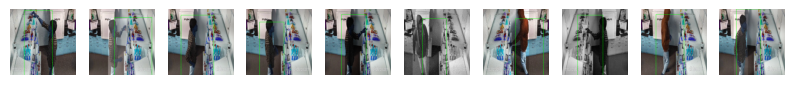

In [28]:
NUM_SAMPLE = 10

images = os.listdir(f'{DESTINATION_PATH}/train/images')[:NUM_SAMPLE]
labels = os.listdir(f'{DESTINATION_PATH}/train/labels')[:NUM_SAMPLE]

plt.figure(figsize=(20, 10))
ax, fig = plt.subplots(1, NUM_SAMPLE, figsize=(10, 10))

for i in range (NUM_SAMPLE):

    image_path = os.path.join(DESTINATION_PATH, 'train', 'images', images[i])
    label_path = os.path.join(DESTINATION_PATH, 'train', 'labels', labels[i])

    image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]


    with open (label_path, 'r', encoding= 'utf-8') as file:
      label , x_center, y_center, width, height = [float(x) for x in file.read().split()]

    x_center *= w
    y_center *= h
    width = int(w * width)
    height = int(h * height)

    x1 = int(x_center - width/2)
    y1 = int(y_center - height/2)
    print(h, w)

    image = cv2.rectangle(image, (x1, y1), (x1+2*width, y1+2*height), (0, 255, 0), 2)

    fig[i].imshow(image)
    fig[i].axis('off')

plt.show()


In [ ]:
from ultralytics import YOLO
import pandas as pd

# Khởi tạo mô hình YOLOv8
# Sử dụng 'yolov8n.pt' (nano) để bắt đầu nhanh, hoặc 'yolov8s.pt' (small) cho hiệu suất tốt hơn
model = YOLO('yolo11n.pt')

print("\nBắt đầu quá trình huấn luyện YOLOv8...")

# Lệnh huấn luyện
# --data: Đường dẫn đến file data.yaml (chứa thông tin về đường dẫn tập train/val và số lượng class)
# --epochs: Số lượng epoch huấn luyện
# --imgsz: Kích thước ảnh đầu vào (ví dụ 640x640)
# --batch: Kích thước batch size (tùy thuộc vào GPU, 16 là mức an toàn)
# --project: Thư mục gốc để lưu kết quả
# --name: Tên thư mục con cụ thể cho lần chạy này
DRIVE_DESTINATION_FOLDER = 'Computer_Vision'
SOURCE_FOLDER_NAME = 'Shoplifting-Detection-1'


RESULTS_PATH = f"/content/drive/MyDrive/{DRIVE_DESTINATION_FOLDER}/{SOURCE_FOLDER_NAME}_trainer"
drive_save_dir_trainer = os.path.dirname(RESULTS_PATH)
os.makedirs(drive_save_dir_trainer, exist_ok=True)
results = model.train(
    data=f"{DESTINATION_PATH}/data.yaml",  # File cấu hình dữ liệu từ Roboflow
    epochs=50,            # Số lượng epoch (thử nghiệm với 50-100)
    imgsz=640,            # Kích thước hình ảnh
    batch=8,             # Kích thước batch
    project=RESULTS_PATH, # Lưu kết quả vào Google Drive
    patience=50,
    name='demo_run'  # Tên lần chạy
    # plots = True
)

In [ ]:
# df = pd.DataFrame()
run_dir = results.save_dir
print(f"Run Dir {run_dir}")
results_csv_path = os.path.join(run_dir, 'results.csv')

print(f"\n3. Huấn luyện hoàn tất. Đường dẫn kết quả: {run_dir}")

# --- Trích xuất dữ liệu mAP từ file CSV ---
if os.path.exists(results_csv_path):
    print("4. Đang đọc và trích xuất chỉ số mAP từ results.csv...")

    # Đọc file CSV, bỏ qua 6 dòng đầu tiên (chứa comments/header không cần thiết)
    df = pd.read_csv(results_csv_path)

# Thong tin columns cua df
df.columns

In [ ]:


def create_custom_subplot_layout():
    """
    Tạo một figure Matplotlib với bố cục 2 hàng:
    - Hàng 1: 1 biểu đồ chính (chiếm toàn bộ chiều rộng).
    - Hàng 2: 3 biểu đồ phụ.
    """

    # 1. Khởi tạo Figure
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle('Detection Metrics', fontsize=16)

    # 2. Định nghĩa GridSpec (Lưới 2 Hàng x 3 Cột)
    # Chúng ta cần 3 cột để chứa 3 biểu đồ phụ ở hàng dưới.
    gs = gridspec.GridSpec(2, 3, figure=fig)

    # 3. Biểu đồ Chính (Hàng 1)
    # Chiếm hàng 0 (đầu tiên), và tất cả các cột (từ 0 đến 2)
    ax_main = fig.add_subplot(gs[0, :])

    # Tạo dữ liệu giả định
    X = np.arange(1, 101)
    Y1 = df['metrics/mAP50(B)']
    Y2 = df['metrics/mAP50-95(B)']

    # Vẽ biểu đồ chính
    ax_main.plot(X, Y1, color='darkblue', linewidth=2)
    ax_main.plot(X, Y2, color='darkgreen', linewidth=2)
    # ax_main.bar(X, df['time'], width= 2)
    ax_main.set_title('mAP50 | mAP50-95')
    ax_main.grid(axis='y', linestyle='--', alpha=0.6)
    ax_main.set_xlabel('Epochs')
    ax_main.set_ylabel('Accuracy')

    # 4. Ba Biểu đồ Phụ (Hàng 2)

    # Biểu đồ phụ 1 (Hàng 1, Cột 0)
    ax_sub1 = fig.add_subplot(gs[1, 0])
    ax_sub1.plot(X, df['train/box_loss'], color='skyblue')
    ax_sub1.grid(axis='y', linestyle='--', alpha=0.6)
    ax_sub1.set_title('Train Box Loss')

    # Biểu đồ phụ 2 (Hàng 1, Cột 1)
    ax_sub2 = fig.add_subplot(gs[1, 1])
    ax_sub2.plot(X, df['train/cls_loss'], color='red')
    ax_sub2.grid(axis='y', linestyle='--', alpha=0.6)
    ax_sub2.set_title('Train Class Loss')

    # Biểu đồ phụ 3 (Hàng 1, Cột 2)
    ax_sub3 = fig.add_subplot(gs[1, 2])
    ax_sub3.plot(X, df['train/dfl_loss'], color='green')
    ax_sub3.set_title('Train dfl Loss')
    ax_sub3.grid(axis='y', linestyle='--', alpha=0.6)

    # 5. Điều chỉnh khoảng cách giữa các biểu đồ để tránh chồng lấn
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Điều chỉnh cho tiêu đề chính

    # 6. Hiển thị Figure
    plt.show()

In [ ]:
create_custom_subplot_layout()